In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import torch
import torchvision
from utils import plot_image
import torch.nn.functional as F
import seaborn as sns

sns.set_style("dark")

### Class labels
airplane: 0 \
automobile: 1\
bird: 2\
cat: 3\
deer: 4\
dog: 5\
frog: 6\
horse: 7\
ship: 8\
truck: 9

In [2]:
ind_to_classname = {0:'airplane',
                    1:'automobile',
                    2:'bird',
                    3:'cat',
                    4:'deer',
                    5:'dog',
                    6:'frog',
                    7:'horse',
                    8:'ship',
                    9:'truck',
                   }

In [3]:
adv = np.load("adversarials/fgsm.npy")

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

real_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

real_loader = torch.utils.data.DataLoader(
    real_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified


In [4]:
class Adv_dataset(torch.utils.data.Dataset):
    def __init__(self, X_adv):
        self.X = X_adv
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], 1
    
adv_dataset = Adv_dataset(adv)
adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=100,
                                            num_workers=0)

In [5]:
from vgg import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

VGG_16 = [64, 64, 'pooling', 128, 128, 'pooling', 256, 256,
          256, 'pooling', 512, 512, 512, 'pooling', 512, 512, 512, 'pooling']

model = VGG(VGG_16)
model = model.to(device)
model.eval()

model.load_state_dict(torch.load('models_weights/vggModel'))

<All keys matched successfully>

network prediction: horse, real class: horse


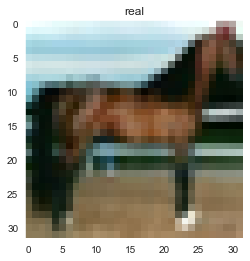

In [51]:
random_index = np.random.randint(0, min(len(adv), len(real_dataset)))
random_real = torch.argmax(model(real_dataset[random_index][0].unsqueeze(0).to(device))).item()
print(f"network prediction: {ind_to_classname[random_real]}, real class: {ind_to_classname[real_dataset.targets[random_index]]}")
plot_image(real_dataset[random_index], title="real")

network prediction on adversarial: truck


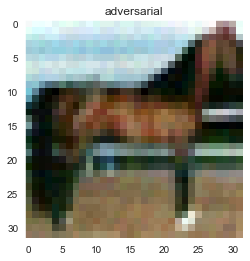

In [52]:
random_adv = torch.argmax(model(torch.from_numpy(adv[random_index]).unsqueeze(0).to(device))).item()
print(f"network prediction on adversarial: {ind_to_classname[random_adv]}")
plot_image(adv[random_index], title='adversarial')

<ipython-input-8-960ae9b39367>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(model(real_dataset[random_index][0].unsqueeze(0).to(device)).detach().cpu()))
<ipython-input-8-960ae9b39367>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(model(torch.from_numpy(adv[random_index]).unsqueeze(0).to(device))).detach().cpu())


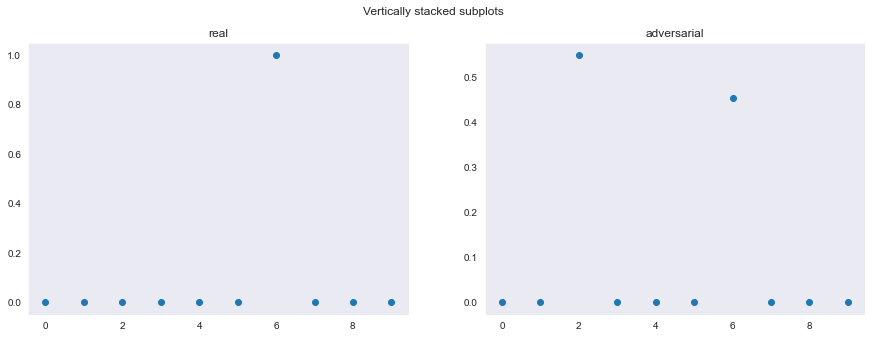

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Vertically stacked subplots')
axs[0].scatter(torch.arange(10),
            F.softmax(model(real_dataset[random_index][0].unsqueeze(0).to(device)).detach().cpu()))
axs[0].title.set_text("real")
axs[1].scatter(torch.arange(10), 
            F.softmax(model(torch.from_numpy(adv[random_index]).unsqueeze(0).to(device))).detach().cpu())
axs[1].title.set_text("adversarial")

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from detectors import *

In [11]:
train_size = 8000
test_size = len(real_dataset) - train_size

train_real, val_real = torch.utils.data.random_split(real_dataset, [train_size, test_size])

In [12]:
train_real_loader = torch.utils.data.DataLoader(
    train_real, batch_size=100, shuffle=False, num_workers=4)
val_real_loader = torch.utils.data.DataLoader(
    val_real, batch_size=100, shuffle=False, num_workers=4)

In [13]:
train_adv, val_adv = torch.utils.data.random_split(adv_dataset, [train_size, test_size])

In [14]:
train_adv_loader = torch.utils.data.DataLoader(
    train_adv, batch_size=100, shuffle=False, num_workers=0)
val_adv_loader = torch.utils.data.DataLoader(
    val_adv, batch_size=100, shuffle=False, num_workers=0)

In [16]:
filt_det = Filter_detector(model)
print("reals as adversarials: ", filt_det.predict(val_real).sum())
print("adversarials as adversarials: ", filt_det.predict(val_adv).sum())

reals as adversarials:  2070
adversarials as adversarials:  2070


In [17]:
def try_detector_model(detector):
    det = ML_adv_detector(model, detector)
    det.fit(train_real_loader, train_adv_loader)
    print(f'number of adversarials among real: {det.predict(val_real_loader).sum()}/{len(val_real)}')
    print(f'number of adversarials among adversarial: {det.predict(val_adv_loader).sum()}/{len(val_adv)}')
    return det

In [18]:
_ = try_detector_model(RandomForestClassifier())

C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


number of adversarials among real: 175/2000


C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


number of adversarials among adversarial: 1861/2000


In [19]:
_ = try_detector_model(LogisticRegression())

C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


number of adversarials among real: 1224/2000


C:\Users\red32\Desktop\CS\neural_networks\cifar10\detectors.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


number of adversarials among adversarial: 1134/2000


In [45]:
det = Combined_det(model, RandomForestClassifier())

In [46]:
det.fit(train_real_loader, train_adv_loader)

<ipython-input-44-b9fd6a28810e>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu()
<ipython-input-44-b9fd6a28810e>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu()


In [47]:
print(det.predict(val_adv_loader).sum())

<ipython-input-44-b9fd6a28810e>:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu()


1860


In [48]:
print(det.predict(val_real_loader).sum())

<ipython-input-44-b9fd6a28810e>:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu()


169
